<a href="https://colab.research.google.com/github/RAvila-bioeng/M.R.AI/blob/monica2/V2_Alzheimers_ResNet_TRUNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [4]:
!pip install -q kagglehub

import kagglehub
import os
import shutil
import random
from collections import defaultdict
import numpy as np

# 1) Descargar el dataset de OASIS con kagglehub
dataset_root = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Dataset descargado en:", dataset_root)
print("Contenido:", os.listdir(dataset_root))

# 2) Carpeta Data dentro del dataset
original_dir = os.path.join(dataset_root, "Data")
print("Contenido de Data:", os.listdir(original_dir))

# ================================
# A partir de aquí, tu pipeline:
# crear Data_subset, luego el split, etc.
# ================================

subset_dir = "./Data_subset"

# Empezar limpio
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
N_PATIENTS_NON_DEMENTED = 120

if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir, exist_ok=True)

classes = [d for d in os.listdir(original_dir)
           if os.path.isdir(os.path.join(original_dir, d))]
print("Clases encontradas en Data:", classes)

for cls in classes:
    src_cls_dir = os.path.join(original_dir, cls)
    dst_cls_dir = os.path.join(subset_dir, cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    print(f"\nProcesando clase: {cls}")

    if "non" not in cls.lower():   # todas menos Non Demented
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Copiando TODAS las imágenes ({len(imgs)})...")
        for fname in imgs:
            shutil.copy2(os.path.join(src_cls_dir, fname),
                         os.path.join(dst_cls_dir, fname))

    else:
        # Non Demented: reducir por nº de pacientes
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Imágenes totales en {cls}: {len(imgs)}")
        print("  Ejemplos de nombres:", imgs[:5])

        images_by_patient = defaultdict(list)
        for fname in imgs:
            parts = fname.split('_')
            patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]
            images_by_patient[patient_id].append(fname)

        print(f"  Pacientes totales detectados: {len(images_by_patient)}")

        patients = list(images_by_patient.keys())
        n_keep = min(N_PATIENTS_NON_DEMENTED, len(patients))
        random.seed(42)
        selected_patients = random.sample(patients, n_keep)

        print(f"  Pacientes que vamos a conservar en {cls}: {n_keep}")

        count_imgs = 0
        for pid in selected_patients:
            for fname in images_by_patient[pid]:
                shutil.copy2(os.path.join(src_cls_dir, fname),
                             os.path.join(subset_dir, cls, fname))
                count_imgs += 1

        print(f"  Imágenes copiadas en {cls} (subset): {count_imgs}")

print("\n✅ Data_subset creado en:", subset_dir)
for cls in os.listdir(subset_dir):
    cls_path = os.path.join(subset_dir, cls)
    if os.path.isdir(cls_path):
        n = len([f for f in os.listdir(cls_path)
                 if f.lower().endswith(valid_exts)])
        print(f"{cls}: {n} imágenes en Data_subset")


Using Colab cache for faster access to the 'imagesoasis' dataset.
Dataset descargado en: /kaggle/input/imagesoasis
Contenido: ['Data']
Contenido de Data: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']
Clases encontradas en Data: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Procesando clase: Non Demented
  Imágenes totales en Non Demented: 67222
  Ejemplos de nombres: ['OAS1_0302_MR1_mpr-3_154.jpg', 'OAS1_0114_MR1_mpr-1_130.jpg', 'OAS1_0150_MR1_mpr-3_129.jpg', 'OAS1_0253_MR1_mpr-3_113.jpg', 'OAS1_0349_MR1_mpr-4_150.jpg']
  Pacientes totales detectados: 266
  Pacientes que vamos a conservar en Non Demented: 120
  Imágenes copiadas en Non Demented (subset): 30805

Procesando clase: Very mild Dementia
  Copiando TODAS las imágenes (13725)...

Procesando clase: Moderate Dementia
  Copiando TODAS las imágenes (488)...

Procesando clase: Mild Dementia
  Copiando TODAS las imágenes (5002)...

✅ Data_subset creado en: ./Data_subset


In [5]:
import os
import shutil
import random
from collections import defaultdict

subset_dir = "./Data_subset"
split_root = "./Data_split_2cls"

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapa de clases originales → clase binaria
CLASS_MAP = {
    "Non Demented": "Non Demented",
    "Very mild Dementia": "Demented",
    "Mild Dementia": "Demented",
    "Moderate Dementia": "Demented",
}

# Limpiar salida
if os.path.exists(split_root):
    shutil.rmtree(split_root)
os.makedirs(split_root, exist_ok=True)

logical_classes = sorted(set(CLASS_MAP.values()))
print("Logical classes:", logical_classes)

# Crear estructura de carpetas
for split in ["train", "val", "test"]:
    for cls in logical_classes:
        os.makedirs(os.path.join(split_root, split, cls), exist_ok=True)

# Agrupar imágenes por (clase lógica, paciente)
class_patient_images = {cls: defaultdict(list) for cls in logical_classes}

for orig_class in os.listdir(subset_dir):
    orig_class_path = os.path.join(subset_dir, orig_class)
    if not os.path.isdir(orig_class_path):
        continue

    if orig_class not in CLASS_MAP:
        print(f"Saltando clase desconocida: {orig_class}")
        continue

    logical_class = CLASS_MAP[orig_class]

    for fname in os.listdir(orig_class_path):
        fpath = os.path.join(orig_class_path, fname)
        if not os.path.isfile(fpath):
            continue

        if not fname.lower().endswith(valid_exts):
            continue

        parts = fname.split("_")
        if len(parts) >= 2 and parts[0].startswith("OAS1"):
            patient_id = parts[0] + "_" + parts[1]
        else:
            patient_id = parts[0]

        class_patient_images[logical_class][patient_id].append(fpath)

# Función de split por pacientes
def split_patients(patients, train_ratio=0.7, val_ratio=0.15, seed=42):
    random.seed(seed)
    patients = list(patients)
    random.shuffle(patients)

    n = len(patients)
    if n == 0:
        return [], [], []

    n_train = max(1, int(train_ratio * n))
    n_val = max(1, int(val_ratio * n))
    n_test = n - n_train - n_val

    if n_test <= 0:
        n_test = 1
        if n_val > 1:
            n_val -= 1
        else:
            n_train = max(1, n_train - 1)

    train_patients = patients[:n_train]
    val_patients = patients[n_train:n_train + n_val]
    test_patients = patients[n_train + n_val:]

    return train_patients, val_patients, test_patients

# Hacer el split y copiar archivos
for logical_class in logical_classes:
    patients_dict = class_patient_images[logical_class]
    patients = list(patients_dict.keys())
    print(f"\nClase '{logical_class}': {len(patients)} pacientes")

    train_p, val_p, test_p = split_patients(patients)

    print(f"  Train: {len(train_p)} pacientes")
    print(f"  Val:   {len(val_p)} pacientes")
    print(f"  Test:  {len(test_p)} pacientes")

    for split_name, split_pat_list in [("train", train_p),
                                       ("val", val_p),
                                       ("test", test_p)]:
        for pid in split_pat_list:
            for src_path in patients_dict[pid]:
                dst_path = os.path.join(
                    split_root,
                    split_name,
                    logical_class,
                    os.path.basename(src_path),
                )
                shutil.copy2(src_path, dst_path)

print("\nCopiado terminado. Comprobando número de imágenes por split y clase...\n")

for split in ["train", "val", "test"]:
    print(f"Split: {split}")
    for cls in logical_classes:
        cls_dir = os.path.join(split_root, split, cls)
        if not os.path.isdir(cls_dir):
            print(f"  {cls}: 0 imágenes (directorio no encontrado)")
            continue
        n_images = sum(
            1 for f in os.listdir(cls_dir)
            if f.lower().endswith(valid_exts)
        )
        print(f"  {cls}: {n_images} imágenes")
    print()


Logical classes: ['Demented', 'Non Demented']

Clase 'Demented': 81 pacientes
  Train: 56 pacientes
  Val:   12 pacientes
  Test:  13 pacientes

Clase 'Non Demented': 120 pacientes
  Train: 84 pacientes
  Val:   18 pacientes
  Test:  18 pacientes

Copiado terminado. Comprobando número de imágenes por split y clase...

Split: train
  Demented: 13298 imágenes
  Non Demented: 22021 imágenes

Split: val
  Demented: 2745 imágenes
  Non Demented: 4331 imágenes

Split: test
  Demented: 3172 imágenes
  Non Demented: 4453 imágenes



In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_dir = "./Data_split_2cls"

# TRANSFORMS TRUNCADOS (recorte central)
train_tfms_trunc = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),           # primero hacemos todas 256x256
    transforms.CenterCrop((160, 160)),       # ⟵ aquí truncas: te quedas con la parte central
    transforms.RandomHorizontalFlip(),       # augment
    transforms.RandomRotation(10),           # augment
    transforms.Resize((224, 224)),           # redimensionas al tamaño estándar de ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms_trunc = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((160, 160)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Datasets con esos transforms
train_ds_trunc = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_tfms_trunc)
val_ds_trunc   = datasets.ImageFolder(root=f"{data_dir}/val",   transform=val_tfms_trunc)
test_ds_trunc  = datasets.ImageFolder(root=f"{data_dir}/test",  transform=val_tfms_trunc)

print("Clases (orden interno, truncado):", train_ds_trunc.classes)

batch_size = 32
train_loader_trunc = DataLoader(train_ds_trunc, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader_trunc   = DataLoader(val_ds_trunc,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_trunc  = DataLoader(test_ds_trunc,  batch_size=batch_size, shuffle=False, num_workers=2)


Clases (orden interno, truncado): ['Demented', 'Non Demented']


In [7]:
from collections import Counter
import numpy as np

targets_trunc = [label for _, label in train_ds_trunc.samples]
class_counts_trunc = Counter(targets_trunc)
print("Imágenes por clase en TRAIN (truncado):", class_counts_trunc)
print("Índice → Clase:", {i: c for i, c in enumerate(train_ds_trunc.classes)})

num_classes_trunc = len(train_ds_trunc.classes)
counts_trunc = np.array([class_counts_trunc[i] for i in range(num_classes_trunc)], dtype=np.float32)
total_trunc = counts_trunc.sum()

class_weights_trunc = total_trunc / (counts_trunc + 1e-6)
class_weights_trunc = class_weights_trunc / class_weights_trunc.min()

print("Pesos de clase usados en la loss (truncado):", class_weights_trunc)


Imágenes por clase en TRAIN (truncado): Counter({1: 22021, 0: 13298})
Índice → Clase: {0: 'Demented', 1: 'Non Demented'}
Pesos de clase usados en la loss (truncado): [1.6559633 1.       ]


In [8]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

resnet_trunc = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = resnet_trunc.fc.in_features
resnet_trunc.fc = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes_trunc)   # 2 clases: ['Demented', 'Non Demented']
)

resnet_trunc = resnet_trunc.to(device)
print("Nueva cabeza de la ResNet (truncado):")
print(resnet_trunc.fc)

class_weights_trunc_tensor = torch.tensor(class_weights_trunc, dtype=torch.float32).to(device)
criterion_trunc = nn.CrossEntropyLoss(weight=class_weights_trunc_tensor)

optimizer_trunc = optim.Adam(resnet_trunc.parameters(), lr=1e-4)


Usando dispositivo: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


Nueva cabeza de la ResNet (truncado):
Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=2, bias=True)
)


In [9]:
def train_one_epoch_trunc(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def eval_model_trunc(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


In [10]:
num_epochs = 10  # o 15 si ves que todavía mejora la val_acc

best_val_acc_trunc = 0.0
best_model_state_trunc = None

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch_trunc(resnet_trunc, train_loader_trunc, optimizer_trunc, criterion_trunc)
    val_loss, val_acc     = eval_model_trunc(resnet_trunc, val_loader_trunc, criterion_trunc)

    print(f"[TRUNC] Epoch {epoch+1}/{num_epochs} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}")

    if val_acc > best_val_acc_trunc:
        best_val_acc_trunc = val_acc
        best_model_state_trunc = resnet_trunc.state_dict().copy()

print("Mejor val_acc (truncado):", best_val_acc_trunc)

if best_model_state_trunc is not None:
    resnet_trunc.load_state_dict(best_model_state_trunc)


[TRUNC] Epoch 1/10 | train_loss=0.2152, train_acc=0.904 | val_loss=0.5505, val_acc=0.820
[TRUNC] Epoch 2/10 | train_loss=0.0738, train_acc=0.972 | val_loss=0.5605, val_acc=0.868
[TRUNC] Epoch 3/10 | train_loss=0.0419, train_acc=0.984 | val_loss=0.5820, val_acc=0.873
[TRUNC] Epoch 4/10 | train_loss=0.0302, train_acc=0.989 | val_loss=0.8394, val_acc=0.844
[TRUNC] Epoch 5/10 | train_loss=0.0277, train_acc=0.991 | val_loss=0.6617, val_acc=0.876
[TRUNC] Epoch 6/10 | train_loss=0.0202, train_acc=0.993 | val_loss=0.6734, val_acc=0.875
[TRUNC] Epoch 7/10 | train_loss=0.0195, train_acc=0.994 | val_loss=0.8290, val_acc=0.868
[TRUNC] Epoch 8/10 | train_loss=0.0155, train_acc=0.994 | val_loss=0.8306, val_acc=0.859
[TRUNC] Epoch 9/10 | train_loss=0.0165, train_acc=0.994 | val_loss=0.8838, val_acc=0.862
[TRUNC] Epoch 10/10 | train_loss=0.0118, train_acc=0.996 | val_loss=0.9249, val_acc=0.870
Mejor val_acc (truncado): 0.8762012436404748


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss_trunc, test_acc_trunc = eval_model_trunc(resnet_trunc, test_loader_trunc, criterion_trunc)
print(f"[TRUNC] Test loss: {test_loss_trunc:.4f}, Test accuracy: {test_acc_trunc:.3f}")

resnet_trunc.eval()
all_labels_trunc = []
all_preds_trunc  = []

with torch.no_grad():
    for images, labels in test_loader_trunc:
        images = images.to(device)
        outputs = resnet_trunc(images)
        _, preds = outputs.max(1)

        all_labels_trunc.extend(labels.numpy())
        all_preds_trunc.extend(preds.cpu().numpy())

all_labels_trunc = np.array(all_labels_trunc)
all_preds_trunc  = np.array(all_preds_trunc)

cm_trunc = confusion_matrix(all_labels_trunc, all_preds_trunc)
print("\n[TRUNC] Matriz de confusión:")
print(cm_trunc)

print("\n[TRUNC] Reporte de clasificación:")
print(classification_report(all_labels_trunc, all_preds_trunc, target_names=train_ds_trunc.classes))


[TRUNC] Test loss: 1.8463, Test accuracy: 0.769

[TRUNC] Matriz de confusión:
[[1843 1329]
 [ 432 4021]]

[TRUNC] Reporte de clasificación:
              precision    recall  f1-score   support

    Demented       0.81      0.58      0.68      3172
Non Demented       0.75      0.90      0.82      4453

    accuracy                           0.77      7625
   macro avg       0.78      0.74      0.75      7625
weighted avg       0.78      0.77      0.76      7625



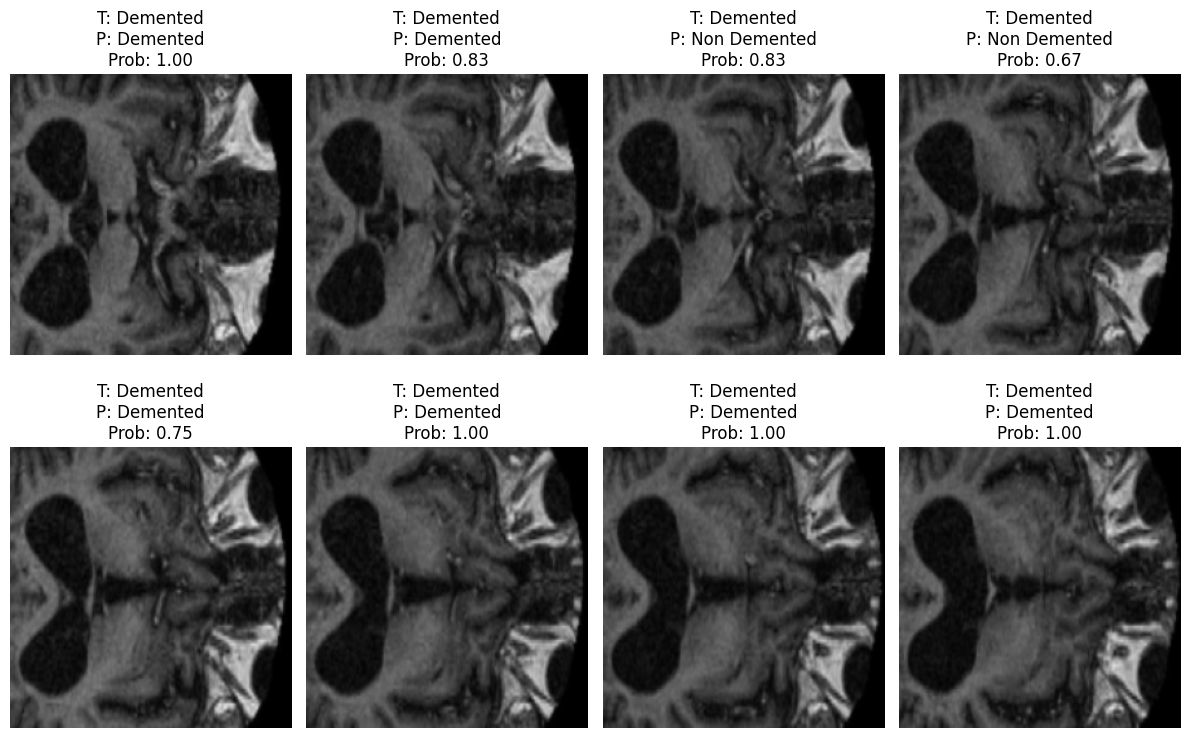

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Elige qué modelo y loader quieres inspeccionar
# Si estás usando el modelo "normal":
model = resnet_trunc
loader = test_loader_trunc
class_names = train_ds_trunc.classes

# Si quieres el modelo truncado, comenta lo de arriba y descomenta esto:
# model = resnet_trunc
# loader = test_loader_trunc
# class_names = train_ds_trunc.classes

model.eval()

# ==============================
# Tomar un batch del test_loader
# ==============================
batch_iter = iter(loader)
images, labels = next(batch_iter)         # images: [B, 3, H, W], labels: [B]

images = images.to(device)
labels = labels.to(device)

# ==============================
# Predicciones del modelo
# ==============================
with torch.no_grad():
    outputs = model(images)              # logits [B, num_classes]
    probs = torch.softmax(outputs, dim=1)  # probabilidades [B, num_classes]
    preds = torch.argmax(probs, dim=1)     # índice de clase predicha [B]

# Probabilidad de la clase predicha (para mostrar en el título)
pred_probs = probs[torch.arange(probs.size(0)), preds]  # [B]

# Pasar todo a CPU + numpy para poder usar matplotlib
images_np = images.cpu().numpy()
labels_np = labels.cpu().numpy()
preds_np = preds.cpu().numpy()
pred_probs_np = pred_probs.cpu().numpy()

# ==============================
# Función para "des-normalizar" imágenes y visualizarlas
# ==============================
# Recuerda que normalizaste con mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]
mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
std  = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)

n_imgs = min(8, images_np.shape[0])   # máximo 8 imágenes

plt.figure(figsize=(12, 8))

for i in range(n_imgs):
    plt.subplot(2, 4, i + 1)

    # image: [3, H, W] → [H, W, 3]
    img = np.transpose(images_np[i], (1, 2, 0))

    # Des-normalizar: img * std + mean
    img = img * std + mean
    img = np.clip(img, 0, 1)   # aseguramos rango [0,1] para matplotlib

    plt.imshow(img)

    true_id = int(labels_np[i])
    pred_id = int(preds_np[i])

    true_label = class_names[true_id]
    pred_label = class_names[pred_id]
    prob_pred  = pred_probs_np[i]

    plt.title(f"T: {true_label}\nP: {pred_label}\nProb: {prob_pred:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Clases: ['Demented', 'Non Demented']
Matriz de confusión:
[[1843 1329]
 [ 432 4021]]

Reporte de clasificación:
              precision    recall  f1-score   support

    Demented       0.81      0.58      0.68      3172
Non Demented       0.75      0.90      0.82      4453

    accuracy                           0.77      7625
   macro avg       0.78      0.74      0.75      7625
weighted avg       0.78      0.77      0.76      7625

F1 por clase: {'Demented': np.float64(0.676702772168166), 'Non Demented': np.float64(0.8203611139447108)}
F1 macro: 0.7485319430564383
F1 weighted: 0.7605992437656681
IoU (Jaccard) por clase: {'Demented': np.float64(0.5113762486126526), 'Non Demented': np.float64(0.6954341058457281)}
IoU (Jaccard) macro: 0.6034051772291904

AUC (clase positiva = Demented): 0.859


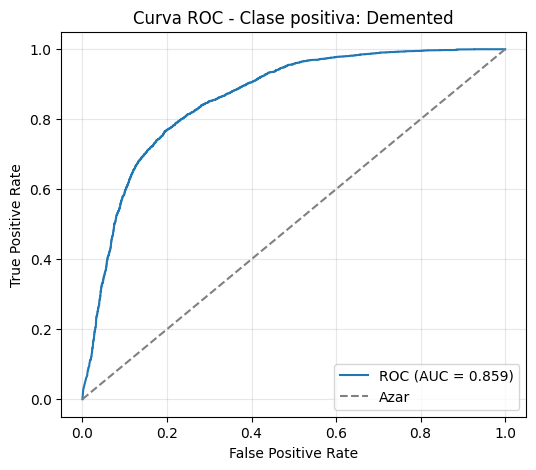

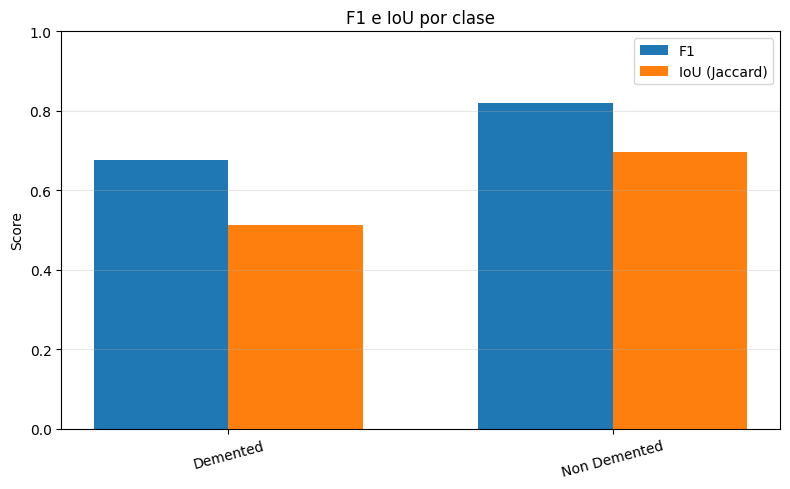

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    auc,
    jaccard_score,
)

# =========================================
# 1. Elige modelo, loader y nombres de clase
# =========================================
# Si quieres evaluar el modelo "normal":
model = resnet_trunc
loader = test_loader_trunc
class_names = train_ds_trunc.classes

# Si quieres evaluar el modelo truncado, comenta lo de arriba y descomenta esto:
# model = resnet_trunc
# loader = test_loader_trunc
# class_names = train_ds_trunc.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# ============================
# 2. Recolectar predicciones
# ============================
all_labels = []
all_preds = []
all_probs = []   # probabilidades por clase, para ROC

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                  # logits [B, num_classes]
        probs = torch.softmax(outputs, dim=1)    # probabilidades [B, num_classes]
        preds = torch.argmax(probs, dim=1)       # [B]

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)   # shape [N, num_classes]

num_classes = len(class_names)
print("Clases:", class_names)

# =====================================================
# 3. Confusion matrix, classification report, F1 scores
# =====================================================
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# F1 por clase y F1 macro/weighted
f1_per_class = f1_score(all_labels, all_preds, average=None)
f1_macro     = f1_score(all_labels, all_preds, average="macro")
f1_weighted  = f1_score(all_labels, all_preds, average="weighted")

print("F1 por clase:", dict(zip(class_names, f1_per_class)))
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)

# ===========================
# 4. IoU / Jaccard por clase
# ===========================
# IoU = Jaccard index, para clasificación: TP / (TP + FP + FN)
# Lo calculamos por clase y también macro.
iou_per_class = jaccard_score(all_labels, all_preds, average=None)
iou_macro     = jaccard_score(all_labels, all_preds, average="macro")

print("IoU (Jaccard) por clase:", dict(zip(class_names, iou_per_class)))
print("IoU (Jaccard) macro:", iou_macro)

# ===========================
# 5. Curva ROC y AUC
# ===========================
# Para binario, elegimos una clase como positiva. Normalmente "Demented".
# Buscamos el índice de 'Demented' en class_names:
try:
    positive_class_idx = class_names.index("Demented")
except ValueError:
    # Si el nombre no coincide, por ejemplo 'dementia'
    # cámbialo aquí a lo que tengas en tu dataset:
    positive_class_idx = 0  # por defecto, la clase 0

y_true_bin = (all_labels == positive_class_idx).astype(int)
y_score = all_probs[:, positive_class_idx]  # prob de clase positiva

fpr, tpr, thresholds = roc_curve(y_true_bin, y_score)
roc_auc = auc(fpr, tpr)

print(f"\nAUC (clase positiva = {class_names[positive_class_idx]}): {roc_auc:.3f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC - Clase positiva: {class_names[positive_class_idx]}")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# ===========================
# 6. Visualizar F1 e IoU por clase
# ===========================
x = np.arange(num_classes)
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, f1_per_class, width, label="F1")
plt.bar(x + width/2, iou_per_class, width, label="IoU (Jaccard)")
plt.xticks(x, class_names, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("F1 e IoU por clase")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
